# When traces cannot be obscured by noise

Experiments for Chapter 3: Performance

In [7]:
import numpy as np
from matplotlib.ticker import FixedLocator

from src.tools.file import store_plt
from src.tools.la import fixed_fixed
from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

import seaborn as sns

from src.tvla.cri import tvla_t_test

init_plots()

In [8]:
TRACE_SET = TraceSetHW(Database.aisy)
TRACE_SET_DESYNC = TraceSetHW(Database.aisy, Pollution(PollutionType.desync, 450))
TRACE_SET_GAUSS = TraceSetHW(Database.aisy, Pollution(PollutionType.gauss, 1500))

X, Y = fixed_fixed(*TRACE_SET.all())
X_DESYNC, _ = fixed_fixed(*TRACE_SET_DESYNC.all())
X_GAUSS, _ = fixed_fixed(*TRACE_SET_GAUSS.all())

A, B = X[~Y], X[Y]
A_DESYNC, B_DESYNC = X_DESYNC[~Y], X_DESYNC[Y]
A_GAUSS, B_GAUSS = X_GAUSS[~Y], X_GAUSS[Y]

PVS = tvla_t_test(X, Y, max_order=1, progress=False)[1]
PVS_DESYNC = tvla_t_test(X_DESYNC, Y, max_order=1, progress=False)[1]
PVS_GAUSS = tvla_t_test(X_GAUSS, Y, max_order=1, progress=False)[1]

In [9]:
def combine(p, v):
    # Balance y-ticks
    p_lim, v_lim = p.get_ylim(), v.get_ylim()
    p_lim_log = np.abs(np.log10(p_lim).astype(int))[1]
    p_step_size = p_lim_log / 5

    p_ticks = np.arange(0, p_lim_log + p_step_size, p_step_size)

    v_step_size = len(p_ticks)
    v_ticks = np.linspace(*v_lim, v_step_size)

    p.yaxis.set_major_locator(FixedLocator(10. ** (-p_ticks)))
    v.yaxis.set_major_locator(FixedLocator(v_ticks))

    # Combine legends
    handles1, labels1 = p.get_legend_handles_labels()
    handles2, labels2 = v.get_legend_handles_labels()
    p.get_legend().remove()
    v.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

    # Remove grid, overlaying p-graphs
    v.grid(False)

def plot(a, b, pvs, p_ylim, v_ylim, title):
    g = sns.lineplot(data=pvs, label="$p$-values", linestyle="--", color=sns.color_palette()[2])
    sns.lineplot(data=[10 ** -5] * len(pvs), label="Threshold ($p$)", linestyle="--", color="#FF000080")
    g.set(ylim=p_ylim, yscale="log", ylabel="$p$-value", xlabel="Sample point index")

    g2 = g.twinx()
    sns.lineplot(data={"LA class A": a.mean(axis=0), "LA class B": b.mean(axis=0)})
    g2.set(ylim=v_ylim, xlim=(0, 2000), ylabel="Mean sample point value", title=title)

    combine(g, g2)

    return g

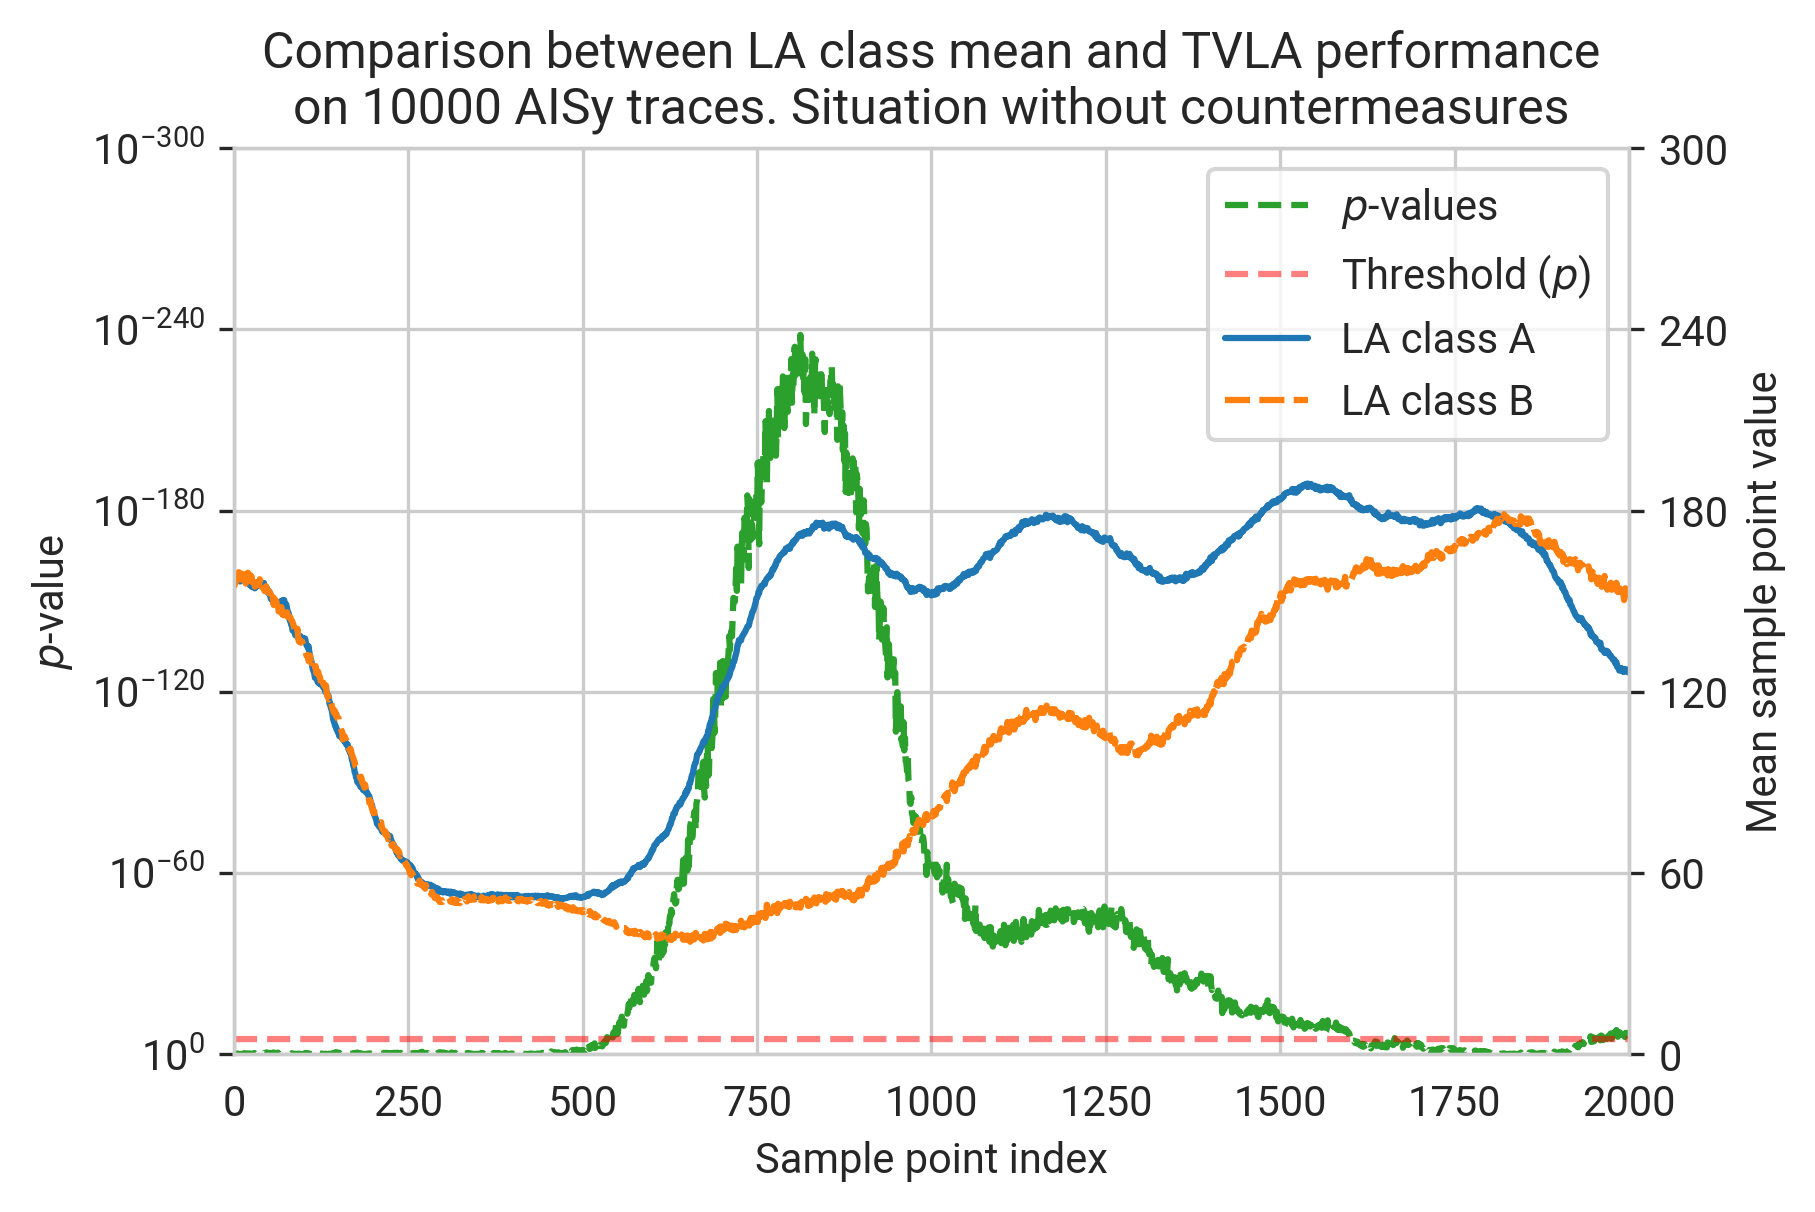

In [10]:
G = plot(A, B, PVS, (1, 10**-300), (0, 300),
     f"Comparison between LA class mean and TVLA performance\non 10000 AISy traces. Situation without countermeasures")

store_sns(G, "noise-obscure")

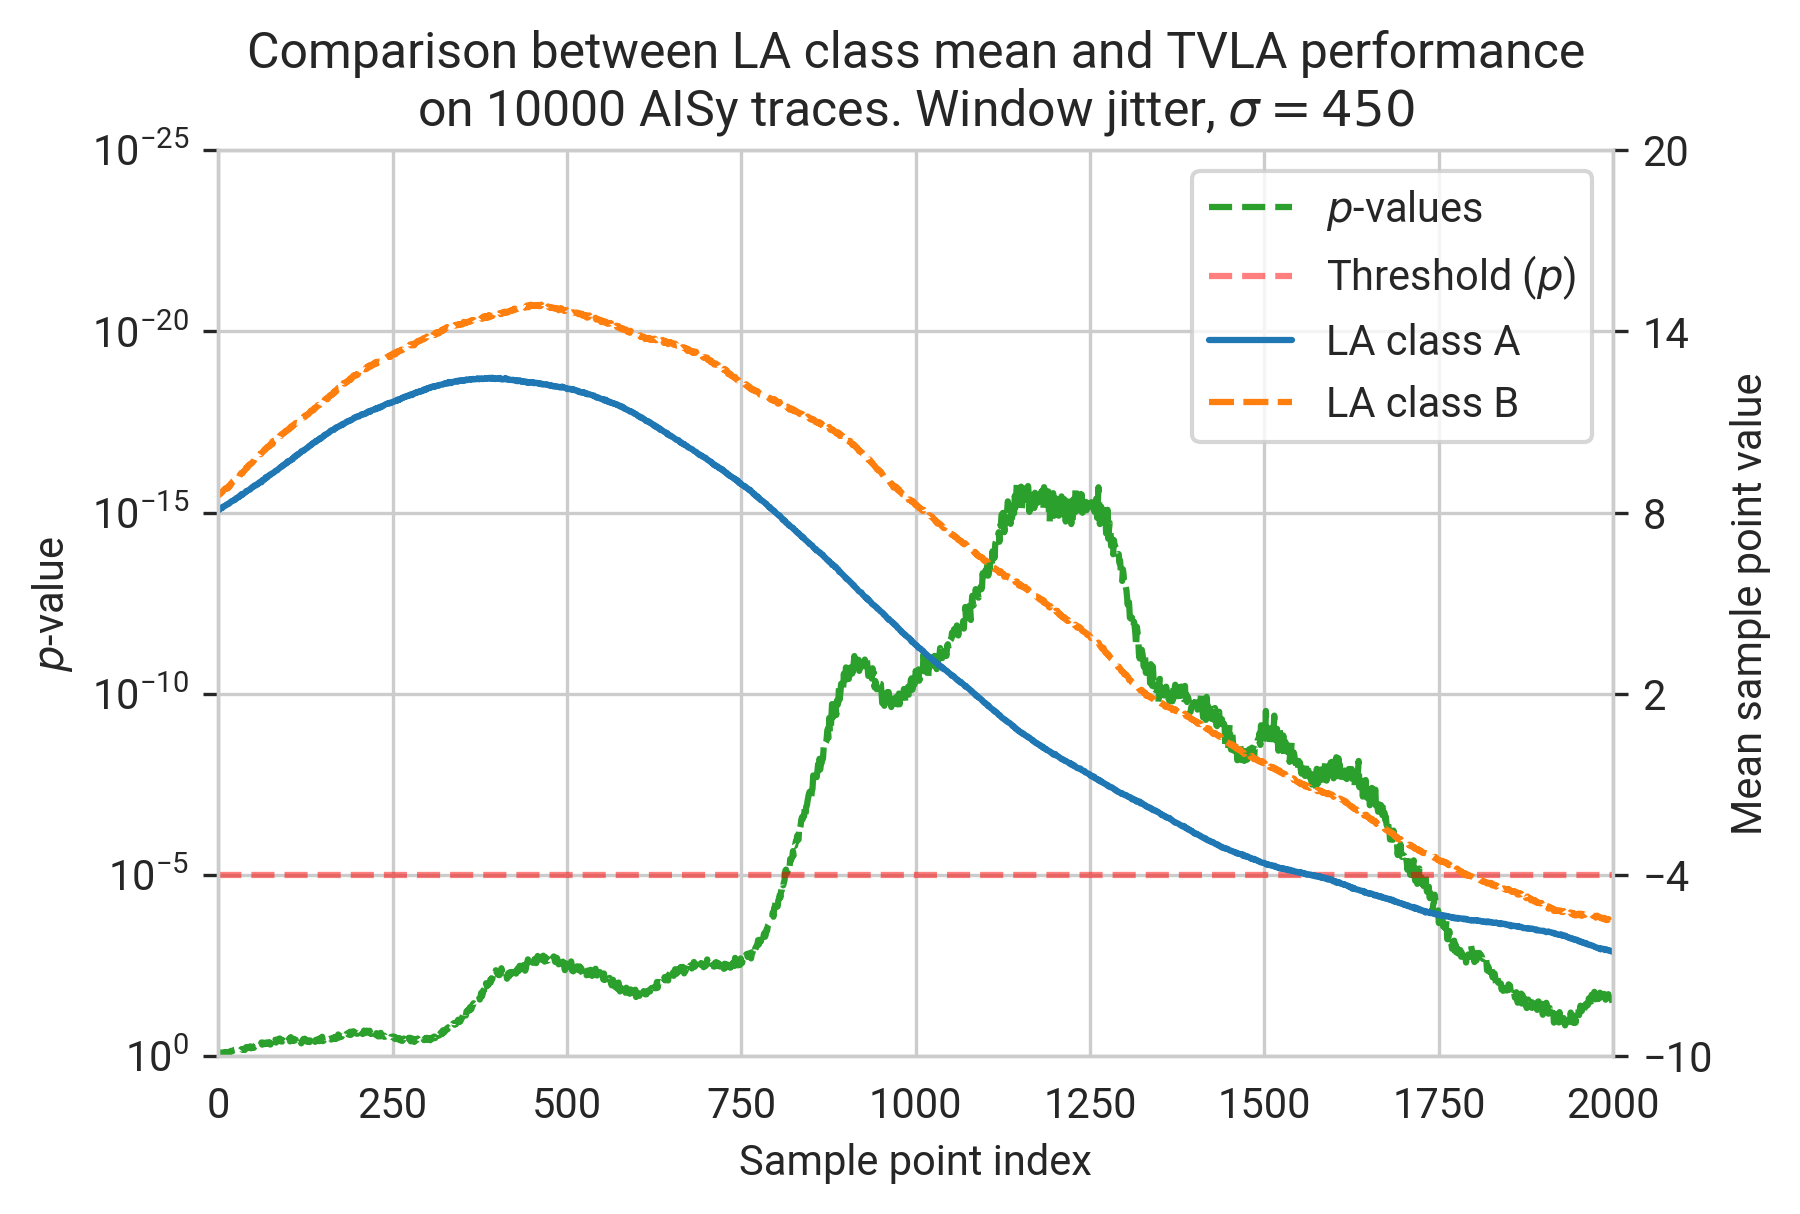

In [11]:
G = plot(A_DESYNC, B_DESYNC, PVS_DESYNC, (1, 10**-25), (-10, 20),
     f"Comparison between LA class mean and TVLA performance\non 10000 AISy traces. Window jitter, $\sigma = 450$")

store_sns(G, "noise-obscure-desync")

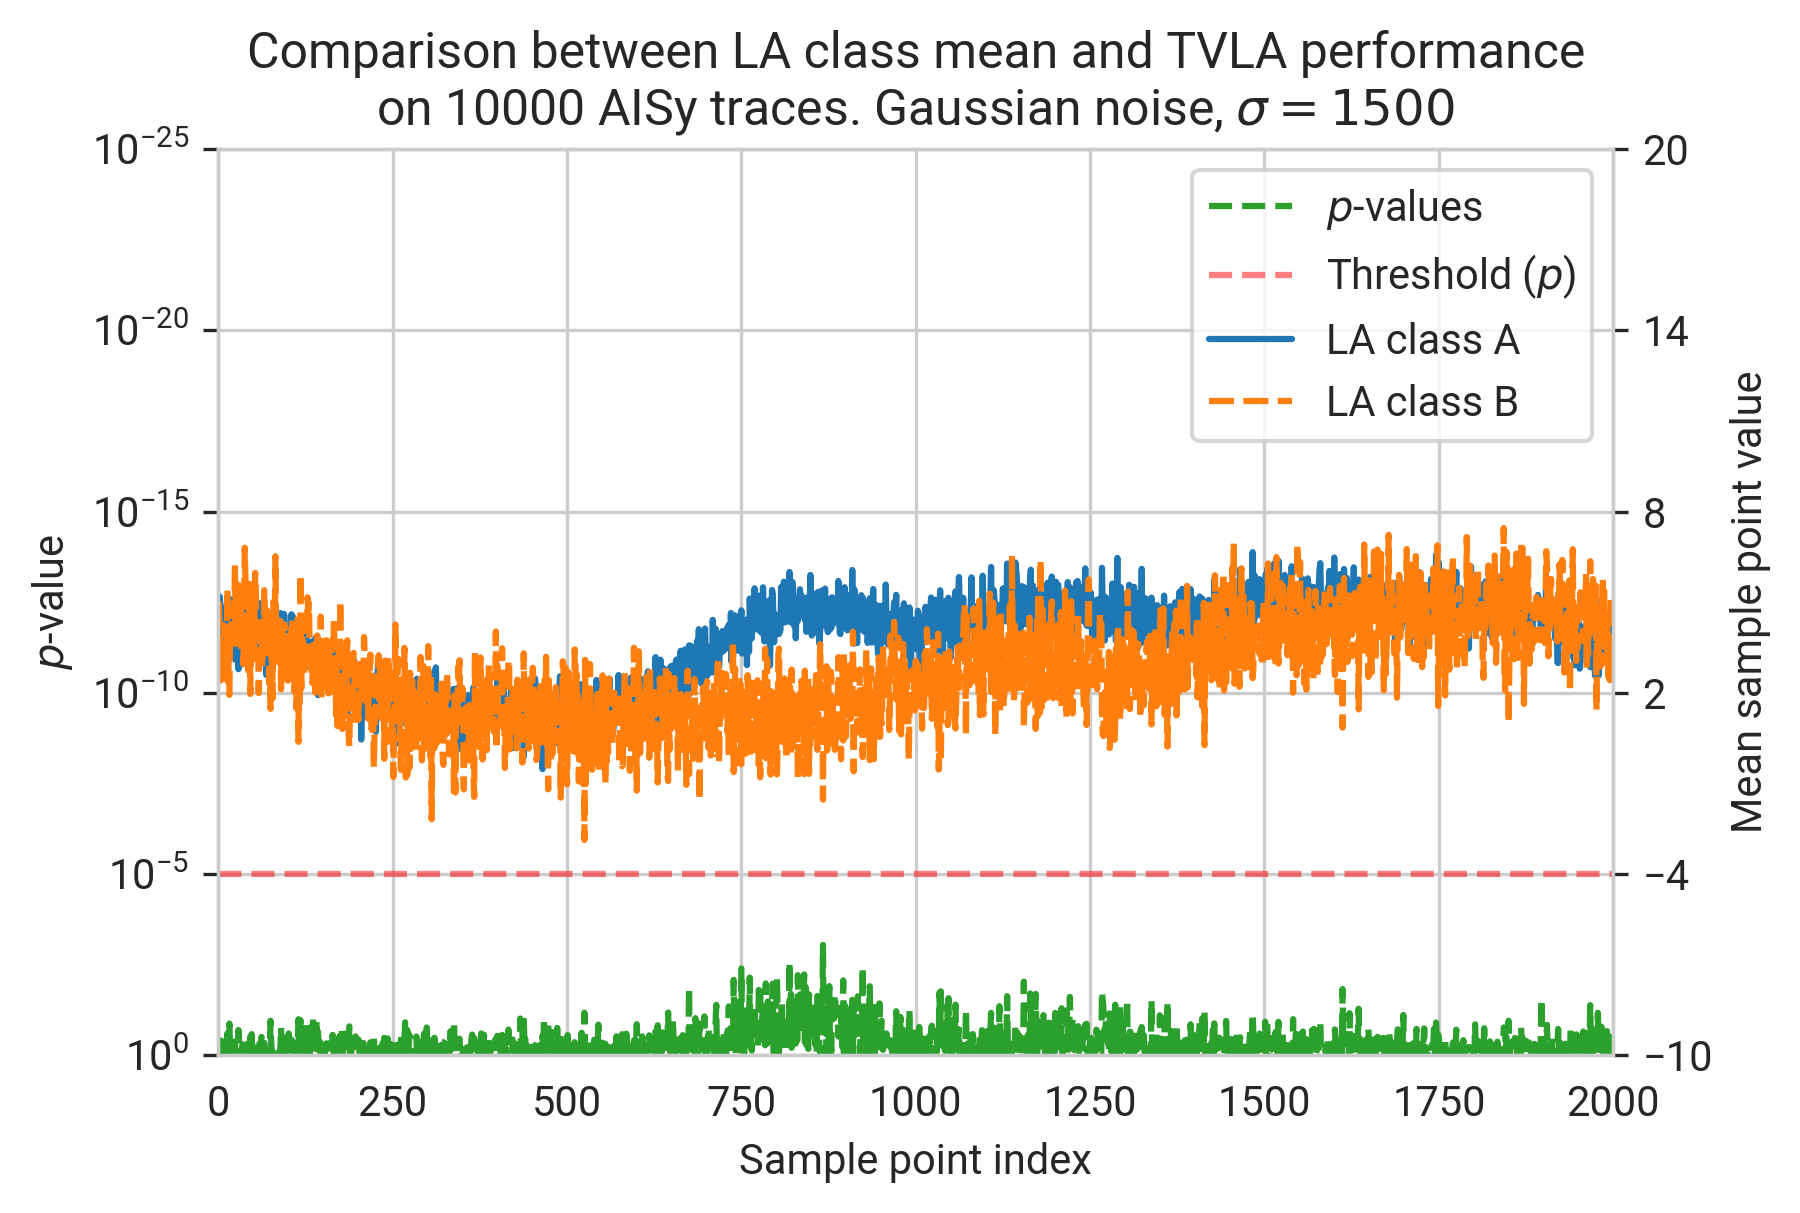

In [12]:
G = plot(A_GAUSS, B_GAUSS, PVS_GAUSS, (1, 10**-25), (-10, 20),
     f"Comparison between LA class mean and TVLA performance\non 10000 AISy traces. Gaussian noise, $\sigma = 1500$")

store_sns(G, "noise-obscure-gauss")